# MCMC Sampler from scratch

Based on https://twiecki.io/blog/2015/11/10/mcmc-sampling/ & extended to gamma/poisson conjugate and a case without an analytical reference-solution.

## Setup

In [1]:
import numpy as np
from functools import partial
from copy import copy

## Plots
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import qqplot
sns.set_style('white')
sns.set_context('talk')
%matplotlib inline

## Distributions & stats
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import uniform
from statsmodels.tsa.stattools import acf

## Example 1: Gaussian mean with known variance

### Gaussian Data

We generate some data to use for estimating the posterior distribution

In [2]:
true_mu = 3.
true_sigma = 1.

np.random.seed(123)
# data = np.random.randn(20)
data = np.random.normal(loc = true_mu, scale = true_sigma, size = 20)

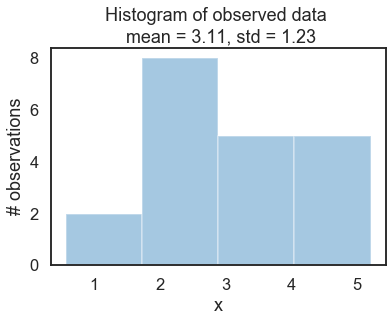

In [3]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(
    title = 'Histogram of observed data \n mean = ' + str(np.round(np.mean(data), 2)) + ', std = ' + str(np.round(np.std(data), 2)),
    xlabel = 'x', 
    ylabel = '# observations'
)

### A Conjugate Prior

Our prior distribution for the mean is the [conjugate distribution](https://en.wikipedia.org/wiki/Conjugate_prior), which is (surprise surprise) a Gaussian distribution. For this example we start with the standard normal distribution $N(0,1)$

In [4]:
prior = norm(0., 1.) 

### Analytical Posterior

We calculate the posterior directly using [Gaussian conjugacy](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution): 

In [5]:
def gaussian_conjugate_posterior(data, prior, sigma_data): 
    
    assert sigma_data >  0, '`sigma_data` parameter must be positive. got '  + sigma_data
    
    ## For better readability
    data_mean = np.mean(data)
    n = len(data)
    sigma2_prior = np.power(prior.args[1], 2) # Sigma^2 of prior
    mu_prior = prior.args[0]
    sigma2_data = np.power(sigma_data, 2) # Sigma^2 of data (known)
    
    # Update sigma    
    updated_sigma = np.sqrt(sigma2_prior * sigma2_data / (sigma2_data + n * sigma2_prior))
    # Update mu
    updated_mu = (mu_prior * sigma2_data + n * data_mean * sigma2_prior) / (sigma2_data + n * sigma2_prior)
    
    return norm(updated_mu, updated_sigma)


In [6]:
posterior_analytical = gaussian_conjugate_posterior(data, prior, sigma_data = 1.)

### Hard-coded Gaussian MCMC Sampler (because we're learning!)

In [7]:
def mcmc_gaussian_sampler(data, samples, sigma_data, prior, mu_init = None, window_size = 0.5):
    
    ## start from a random point in the prior dist unless one is specified
    if mu_init is None:
        mu_init = prior.rvs(size = 1)[0]
    
    ## Get started with the first state: likelihood (with known variance) & prior probability 
    current_mu = mu_init
    current_likelihood = norm(current_mu, sigma_data).pdf(data).prod()
    current_prior_prob = prior.pdf(current_mu)
    
    progress = [current_mu]
    
    for i in range(samples):
        # Random suggestion around the current state with a given window size
        proposal_mu = norm(current_mu, window_size).rvs(size = 1)[0]
        proposal_likelihood = norm(proposal_mu, sigma_data).pdf(data).prod()
        proposal_prior_prob = prior.pdf(proposal_mu)
               
        ratio = (proposal_likelihood * proposal_prior_prob) / (current_likelihood * current_prior_prob)

        # Acceptance criteria: 
        if np.random.rand() < ratio: 
            current_mu = proposal_mu
            current_likelihood = proposal_likelihood
            current_prior_prob = proposal_prior_prob

        progress.append(current_mu)

    return progress

### MCMC Sampling & Burn

In [8]:
mcmc_samples = mcmc_gaussian_sampler(
    data = data,
    samples = 15000,
    sigma_data = 1,
    prior = prior,
    mu_init = 0
)

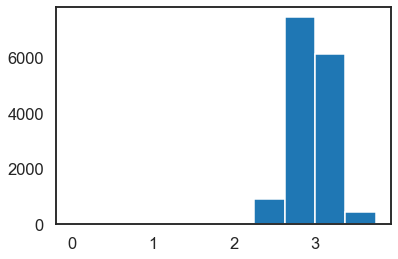

In [9]:
_ = plt.hist(mcmc_samples)

The reason we have values around 0 is because of the starting point we selected. We can "chop off" the beginning of the chain based on some rules (AKA "burn"). Here we look at the first time the chain falls inside the $[10\%,90\%]$ posterior interval 

In [10]:
sample_from = np.min(np.where(
    (mcmc_samples >= np.quantile(mcmc_samples, 0.1)) & \
    (mcmc_samples <= np.quantile(mcmc_samples, 0.9))
))

In [11]:
print('Burn rate is ' + str(round(100 * sample_from / len(mcmc_samples), 2)) + '% from position ' + str(sample_from))

Burn rate is 0.11% from position 16


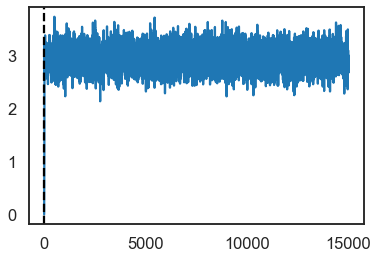

In [12]:
ax = plt.subplot()
_ = ax.plot(mcmc_samples)
_ = ax.axvline(x = sample_from, color = 'k', linestyle='dashed')

### Comparing MCMC to Analytical Gaussian

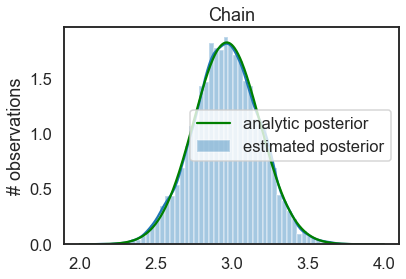

In [13]:
ax = plt.subplot()
x_values = np.linspace(2, 4, 500)
_ = sns.distplot(mcmc_samples[sample_from:], ax = ax, label = 'estimated posterior')
# ax.hist(mcmc_samples[sample_from:])
_ = ax.plot(x_values, posterior_analytical.pdf(x_values), color = 'green', label = 'analytic posterior')
_ = ax.set(title = 'Chain', ylabel = '# observations')
_ = ax.legend()

In [14]:
print({
    'analytical mean': np.round(posterior_analytical.args[0], 3),
    'sampled mean': np.round(np.mean(mcmc_samples), 3),
    'analytical sd': np.round(posterior_analytical.args[1], 3),
    'sampled sd': np.round(np.std(mcmc_samples), 3)
})

{'analytical mean': 2.966, 'sampled mean': 2.963, 'analytical sd': 0.218, 'sampled sd': 0.226}


### Changing `windows_size` param

The `window_size` parameter (which defines where our next guess will fall around the current state) can play an important role in our MCMC behaviour as these two examples demonstrate:

In [15]:
mcmc_samples_wide_window = mcmc_gaussian_sampler(
    data = data, 
    samples = 1000,
    sigma_data = 1,
    prior = prior,
    window_size = 4,
    mu_init = 0
)

In [16]:
mcmc_samples_narrow_window = mcmc_gaussian_sampler(
    data = data, 
    samples = 1000,
    sigma_data = 1,
    prior = prior,
    window_size = 0.1,
    mu_init = 0
)

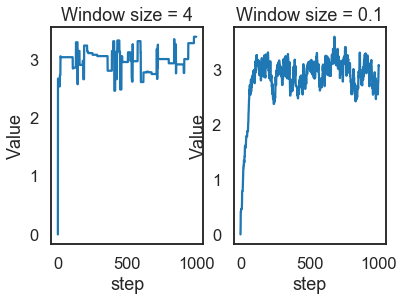

In [17]:
ax1 = plt.subplot(1,2,1)
_ = ax1.plot(mcmc_samples_wide_window)
_ = ax1.set(title='Window size = 4',   xlabel='step', ylabel='Value')

ax2 = plt.subplot(1,2,2)
_ = ax2.plot(mcmc_samples_narrow_window)
_ = ax2.set(title='Window size = 0.1', xlabel='step', ylabel='Value')

A large window size (4) will mean we often stay at the same state for a long time, while a small window size will result in higher burn and higher correlation between neighboring samples. This can be represented by the auto-correlation plot, which provides an interesting measure for the quality of the sampling process (ideally we want to get IID dist after a short "warm up" period)

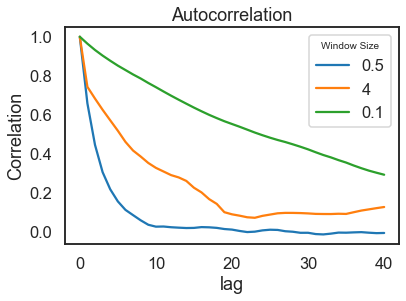

In [18]:
ax = plt.subplot()
_ = ax.plot(acf(mcmc_samples, fft = False), label = '0.5')
_ = ax.plot(acf(mcmc_samples_wide_window, fft = False), label = '4')
_ = ax.plot(acf(mcmc_samples_narrow_window, fft = False), label = '0.1')
_ = ax.legend(title = 'Window Size')
_ = ax.set(title='Autocorrelation', xlabel='lag', ylabel='Correlation')

## More Generic MCMC Sampler for a Single Parameter

To save some code replication and make our code look nicer (and yes, this is also a `python` exercise...), let's define a class that calculates prior probability and likelihood for a given parameter (in a single param distribution)

In [19]:
class mcmcSingleParamProposal:
    '''This class takes a proposed value of a parameter `param` and returns prior distribution and likelihood. 
    We provide for discrete / continuous distributions from `scipy.stats` and also check for miss-pecification. 
    
    Args:
        param (real): A real valued single parameter of the sampling distribution.
        data (list): A list of observed samples (should be in the support of the likelihood function)
        prior: A `scipy` distribution object representing the prior dist. 
        likelihood: A `scipy` distribution object representing the likelihood model. When using distributions with more than one parameter for the likelihood function make sure you fix all parameters except the parameters of interest (e.g. in the case of a Gaussian with a known variance). You can do that by using the `partial` function (for example '= partial(norm, scale = 1)')
        check_suport (False): should we raise and error if the likelihood or prior probability are exactly 0?
    
    Attributes:
        param: The original candidate parameter
        prior: Prior probability of the candidate 
        likelihood: Data likelihood under the param + likelihood function    
    '''
    
    
    def __init__(self, param, data, prior, likelihood, check_support = False):
        self.param = param
        
        ## Caculate prior probability of param
        if hasattr(prior.dist, 'pmf'):
            self.prior = prior.pmf(param)
        elif hasattr(prior.dist, 'pdf'):
            self.prior = prior.pdf(param)
        else:
            raise NameError('Prior dist object does not have a PDF/PMF')
        

        ## Calculate likelihood
        if hasattr(likelihood(param).dist, 'pmf'):
            self.likelihood = likelihood(param).pmf(data).prod()
        elif hasattr(likelihood(param).dist, 'pdf'):
            self.likelihood = likelihood(param).pdf(data).prod()
        else:
            raise NameError('Likelihood function does not have a PDF/PMF')
        
        ## Validation
        if check_support:
            if self.prior == 0:
                raise NameError('`param` is outside the support of the prior distribution ')
            if self.likelihood == 0:
                raise NameError('Data likelihood is 0. Consider a different model')


In [20]:
def mcmc_single_param_sampler(data, samples, prior, likelihood, sampling_dist, param_init = None):
    '''This functions provied MCMC based samples for single parameter distributiobs (e.g. Poisson, know variance gaussians, etc.)
    
    Args: 
        data: a list of observed data
        samples: number of samples from the posterior distributions (MCMC chain length)
        prior: `scipy` distribution object representing prior distribution
        likelihood: A function that accepts a single `param` and data and returns likelihood. When using distributions with more than one parameter for the likelihood function make sure you fix all parameters except the parameters of interest (e.g. in the case of a Gaussian with a known variance). You can do that by using the `partial` function (for example '= partial(norm, scale = 1)') 
        sampling_dist: A `scipy` distorbution object that can accept `param` and return a candidate value for the chain 
        param_init (default None): Initial value for the chain
        
    Returns: A list of samples
    '''
    
    if param_init is None:
        param_init = prior.rvs(size = 1)[0]
        
    current = mcmcSingleParamProposal(param_init, data, prior, likelihood)
    progress = [current.param]
    
    for i in range(samples):
        # Random suggestion
        mu_proposal = sampling_dist(current.param).rvs(size = 1)[0]
        proposal = mcmcSingleParamProposal(mu_proposal, data, prior, likelihood)
        
        ratio = (proposal.likelihood * proposal.prior) / (current.likelihood * current.prior)

        # Acceptance criteria: 
        if np.random.rand() < ratio: 
            current = copy(proposal)

        progress.append(current.param)

    return progress

Let's also write a more generic percentile-based burn function:

In [21]:
def suggest_quantile_burn(samples, min_p = 0.1, max_p = 0.9):
    '''Calculates "burn rate" (how many samples to consider as disposable "warmup" for the MCMC) based on quantiles. The idea is to look at the entire chain and start using samples only after the first samples falls inside the [10%,90%] qunatile range (based on the entire sample)
    Args:
        samples: A list of numeric sampled values 
        min_p / max_p: the lower / upper quantile to consider. First obs to fall withing this range will be the beginning of the "post warmup" stage
    '''

    minq = np.quantile(samples, min_p)
    maxq = np.quantile(samples, max_p)
    
    assert minq < maxq, 'Only one value detected. Check simulation!'
    
    return np.min(np.where((samples > minq) & (samples < maxq))[0])

## Example 1 Revisited

We re-calculate the same posterior sample using our generic sampler. Note the use of `partial`...

In [24]:
mcmc_samples_sp_gaussian = mcmc_single_param_sampler(
    data = data, 
    samples = 15000, 
    prior = prior, 
    likelihood = partial(norm, scale = 1), # sigma data = 1 
    sampling_dist = partial(norm, scale = 0.5), # window size = 0.5
    param_init = 0
) 

Since we don't expect the same results we can compare empirical distributions by plotting percentiles against one another:

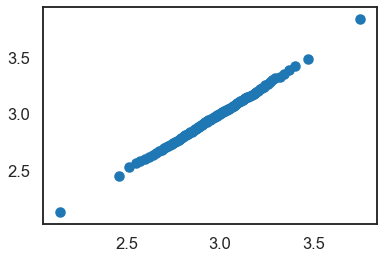

In [25]:
ax = plt.subplot()
p = np.linspace(0, 1, 101)

_ = ax.scatter(
    np.quantile(mcmc_samples[sample_from:], p),
    np.quantile(mcmc_samples_sp_gaussian[sample_from:], p)
)

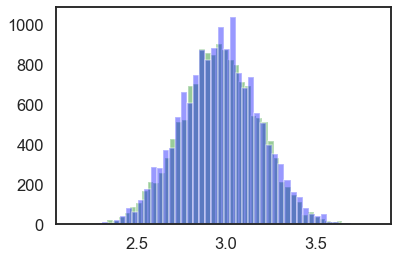

In [26]:
ax = plt.subplot()
_ = sns.distplot(mcmc_samples[sample_from:], kde=False, ax=ax, color = 'green')
_ = sns.distplot(mcmc_samples_sp_gaussian[sample_from:], kde=False, ax=ax, color = 'blue')

Looks Good!

## Example 2:  Gamma / Poisson conjugate

### Data

In [27]:
true_lambda = 4

np.random.seed(123)
data = np.random.poisson(lam = true_lambda, size = 20)

### Prior

The conjugate distribution for Poisson is the Gamma dist. We choose $\alpha$ and $\beta$ such that $\alpha / \beta = 2$

In [28]:
prior = gamma(a = 1, scale = 1)

### Analytical Posterior

In [29]:
def gamma_conjugate_posterior(data, prior): 
    return gamma(
        a = prior.kwds['a'] + sum(data), 
        scale = 1/(1/prior.kwds['scale'] + len(data))
    )

In [30]:
posterior_analytical = gamma_conjugate_posterior(data, prior)
x_values = np.linspace(0,10,100)

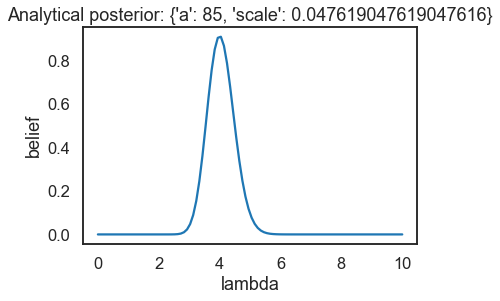

In [31]:
ax = plt.subplot()
ax.plot(x_values, posterior_analytical.pdf(x_values))
_ = ax.set(
    xlabel = 'lambda', 
    ylabel = 'belief', 
    title = 'Analytical posterior: ' + str(posterior_analytical.kwds)
)

### MCMC Sampling

In [32]:
mcmc_samples = mcmc_single_param_sampler(
    data = data, 
    samples = 15000,
    prior = prior,
    likelihood = poisson,
    sampling_dist = partial(norm, scale = 0.5),
    param_init = 1
)

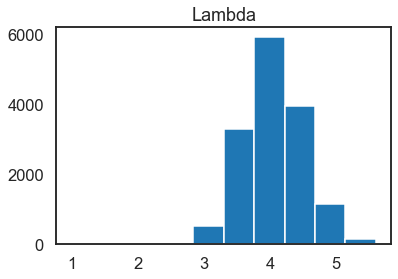

In [33]:
ax1 = plt.subplot()
_ = ax1.hist(mcmc_samples)
_ = ax1.set(title = 'Lambda')

In [34]:
sample_from = suggest_quantile_burn(mcmc_samples)

In [35]:
print('Burn rate is ' + str(round(100 * sample_from / len(mcmc_samples), 2)) + '%')

Burn rate is 0.05%


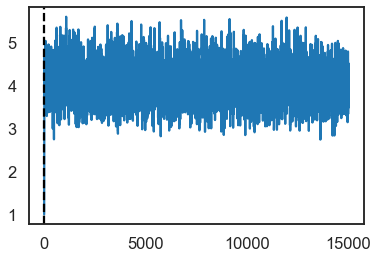

In [36]:
ax = plt.subplot()
_ = ax.plot(mcmc_samples)
_ = ax.axvline(x = sample_from, color = 'k', linestyle='dashed')

### Comparison to analytical

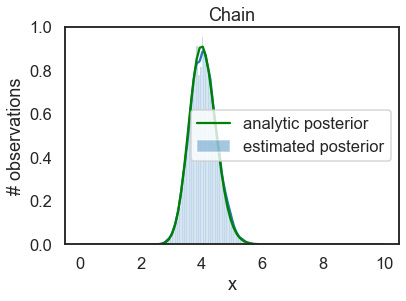

In [37]:
ax = plt.subplot()
sns.distplot(mcmc_samples[sample_from:], ax = ax, label = 'estimated posterior')
# ax.hist(mcmc_samples[sample_from:])
_ = ax.plot(x_values, posterior_analytical.pdf(x_values), color = 'green', label = 'analytic posterior')
_ = ax.set(title = 'Chain', xlabel = 'x', ylabel = '# observations')
_ = ax.legend()

## Example 3: Non-Conjugate Uniform / Poisson

We replace our prior with a uniform $[1,6]$ prior. Unfortunately we don't have an analytical solution to compare to...

In [42]:
mcmc_samples = mcmc_single_param_sampler(
    data = data, 
    samples = 15000,
    prior = uniform(1, 5), # formulation is [loc, loc+scale]
    likelihood = poisson,
    sampling_dist = partial(norm, scale = 0.5),
    param_init = 1
)

In [43]:
sample_from = suggest_quantile_burn(mcmc_samples)

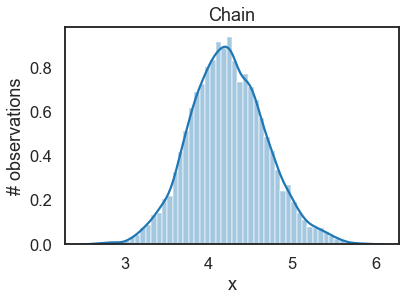

In [44]:
ax = plt.subplot()
sns.distplot(mcmc_samples[sample_from:], ax = ax, label = 'estimated posterior')
_ = ax.set(title = 'Chain', xlabel = 'x', ylabel = '# observations')

And as expected, with a more dispersed prior our posterior variance increases...